# GTSRB - German Traffic Sign Recognition Benchmark

Setup & Imports

In [2]:
# Core
import os
import random
import numpy as np
import pandas as pd


# Image processing
import cv2
from PIL import Image


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# ML / DL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models


# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
IMG_HEIGHT = 30
IMG_WIDTH = 30
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 30
SEED = 42


np.random.seed(SEED)
tf.random.set_seed(SEED)

Dataset Path

In [10]:
import kagglehub
data_dir = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")


Using Colab cache for faster access to the 'gtsrb-german-traffic-sign' dataset.


Load Metadata

In [9]:
train_df = pd.read_csv(os.path.join(data_dir, "Train.csv"))
test_df = pd.read_csv(os.path.join(data_dir, "Test.csv"))


NUM_CLASSES = train_df["ClassId"].nunique()
print("Number of classes:", NUM_CLASSES)

Number of classes: 43


Class Labels

In [11]:
CLASSES = {
0: 'Speed limit 20 km/h', 1: 'Speed limit 30 km/h', 2: 'Speed limit 50 km/h',
3: 'Speed limit 60 km/h', 4: 'Speed limit 70 km/h', 5: 'Speed limit 80 km/h',
6: 'End of speed limit 80 km/h', 7: 'Speed limit 100 km/h',
8: 'Speed limit 120 km/h', 9: 'No passing',
10: 'No passing > 3.5t', 11: 'Right-of-way', 12: 'Priority road',
13: 'Yield', 14: 'Stop', 15: 'No vehicles',
16: 'No vehicles > 3.5t', 17: 'No entry', 18: 'General caution',
19: 'Dangerous curve left', 20: 'Dangerous curve right',
21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road',
24: 'Road narrows right', 25: 'Road work', 26: 'Traffic signals',
27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing',
30: 'Beware of ice/snow', 31: 'Wild animals', 32: 'End restrictions',
33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only',
36: 'Go straight or right', 37: 'Go straight or left',
38: 'Keep right', 39: 'Keep left', 40: 'Roundabout mandatory',
41: 'End of no passing', 42: 'End no passing > 3.5t'
}

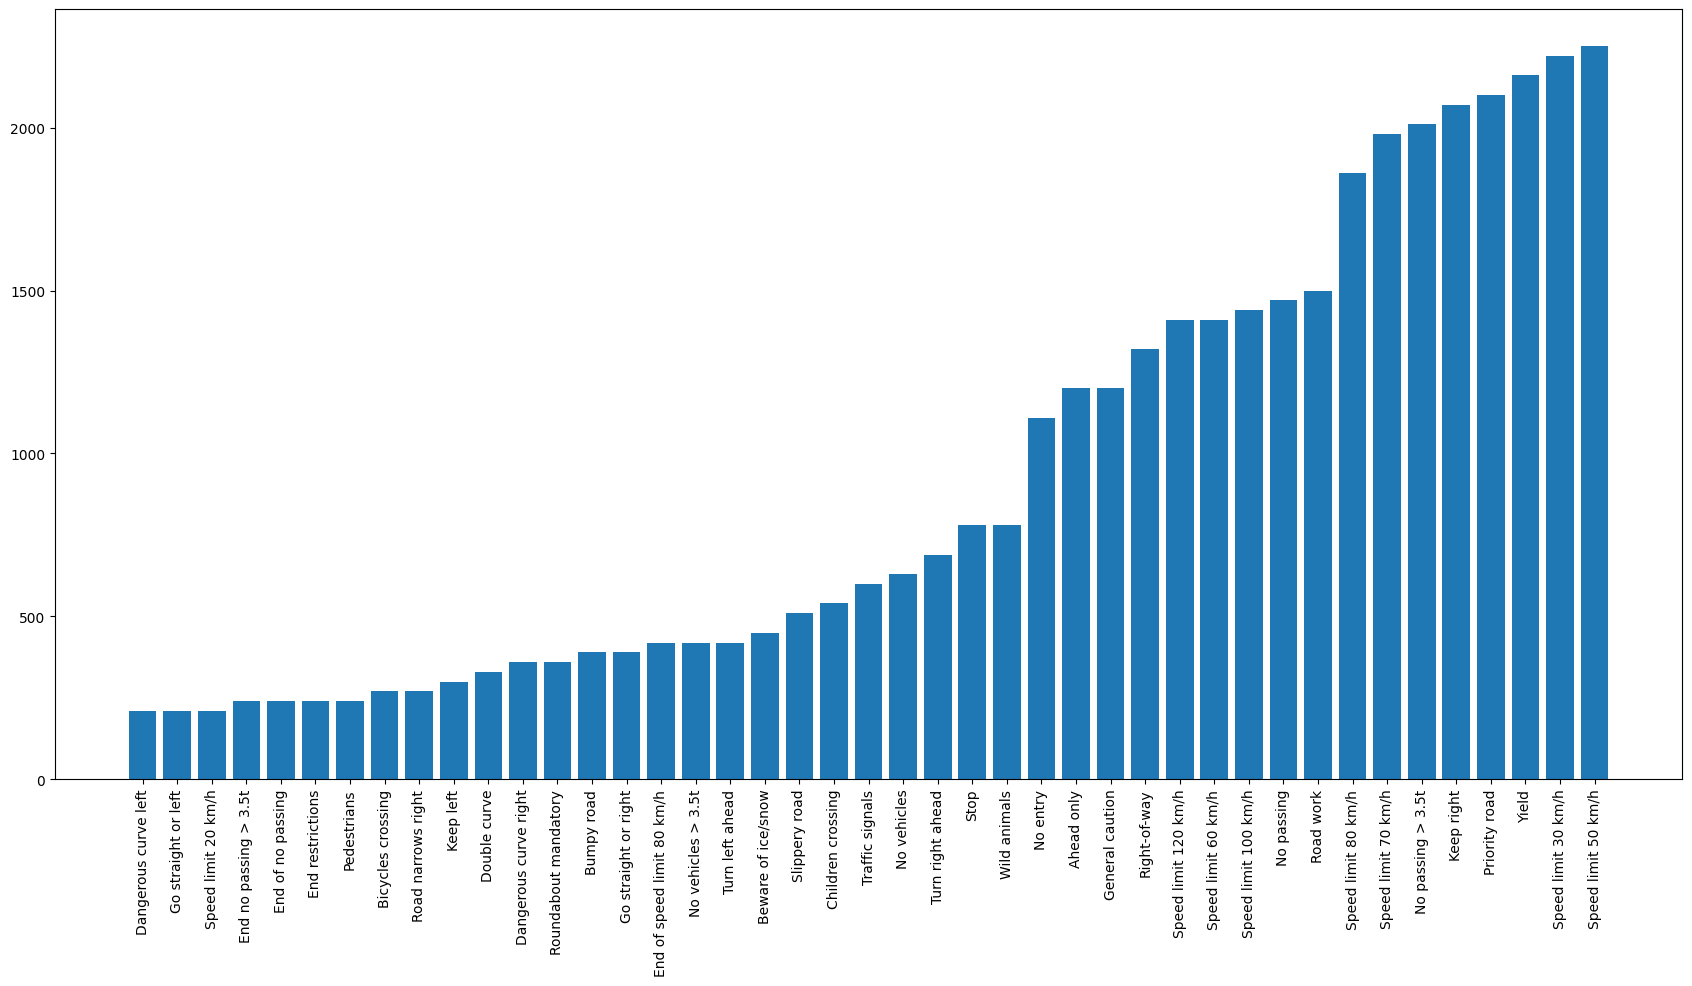

In [13]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(CLASSES[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

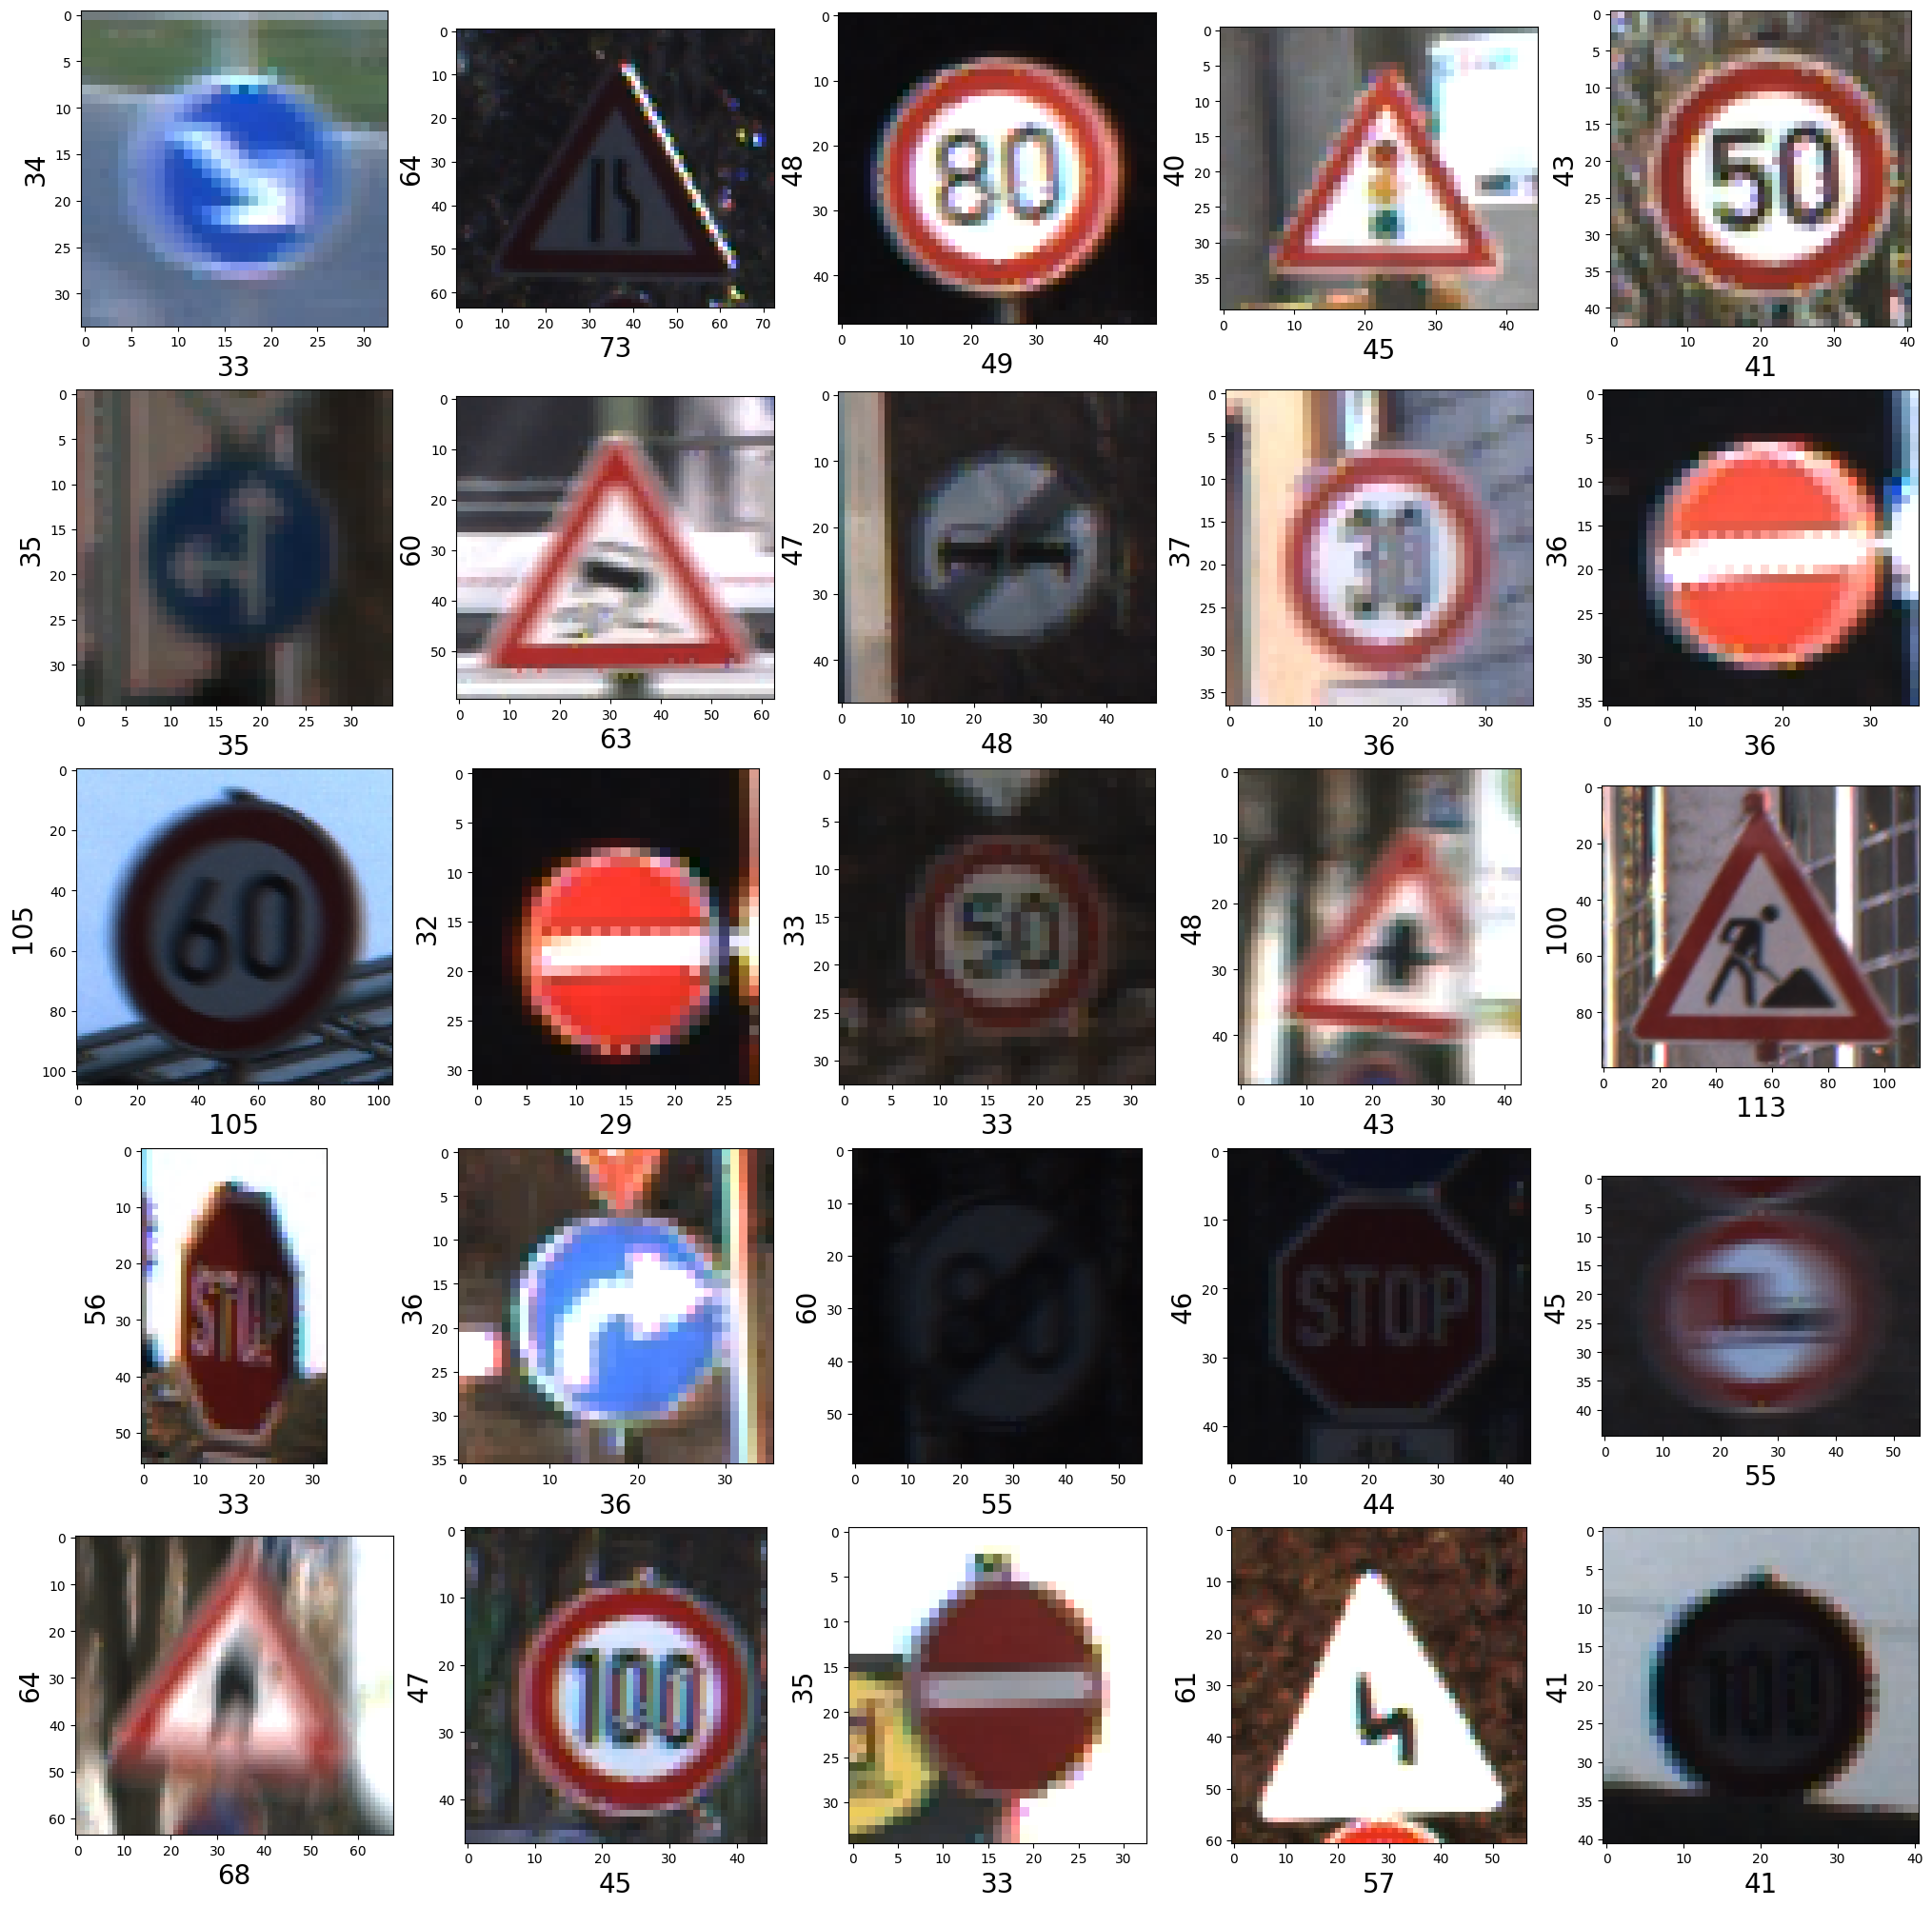

In [15]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(visible=False)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

Load & Preprocess Training Images

In [16]:
X, y = [], []

for class_id in range(NUM_CLASSES):
    class_dir = os.path.join(train_path, str(class_id))
    for img_name in os.listdir(class_dir):
        try:
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            X.append(img)
            y.append(class_id)
        except Exception as e:
            print(f"Failed loading {img_name}: {e}")

X = np.array(X, dtype=np.float32) / 255.0
y = np.array(y)

print("Images:", X.shape)
print("Labels:", y.shape)

Images: (39209, 30, 30, 3)
Labels: (39209,)


Train / Validation Split

In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val = keras.utils.to_categorical(y_val, NUM_CLASSES)

tf.data Pipeline

In [18]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Data Augmentation

In [19]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
])

CNN Model (Clean Architecture)

In [20]:
model = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    data_augmentation,

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,523 (923.92 KB)

 Trainable params: 236,075 (922.17 KB)

 Non-trainable params: 448 (1.75 KB)

Train Model

In [21]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 64s 68ms/step - accuracy: 0.3387 - loss: 2.5133 - val_accuracy: 0.8344 - val_loss: 0.5064
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 57s 66ms/step - accuracy: 0.7626 - loss: 0.7422 - val_accuracy: 0.9296 - val_loss: 0.2107
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 62s 73ms/step - accuracy: 0.8645 - loss: 0.4184 - val_accuracy: 0.9481 - val_loss: 0.1519
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 56s 66ms/step - accuracy: 0.9025 - loss: 0.3048 - val_accuracy: 0.9606 - val_loss: 0.1109
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 58s 68ms/step - accuracy: 0.9189 - loss: 0.2505 - val_accuracy: 0.9583 - val_loss: 0.1256
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 57s 67ms/step - accuracy: 0.9340 - loss: 0.2042 - val_accuracy: 0.9692 - val_loss: 0.0941
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 84s 69ms/step - accuracy: 0.9355 - loss: 0.2027 - val_accuracy: 0.9697 - val_loss: 0.0928
Epoch 8/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 57s 66ms/step - accuracy: 0.9438 - loss: 0.1773 - 

Evaluation on Test Data

In [24]:
X_test, y_test = [], []

for _, row in test_df.iterrows():
    img = Image.open(os.path.join(data_dir, row['Path'])).convert('RGB')
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    X_test.append(np.array(img))
    y_test.append(row['ClassId'])

X_test = np.array(X_test, dtype=np.float32) / 255.0
y_test = np.array(y_test)

pred = np.argmax(model.predict(X_test), axis=1)

print("Test Accuracy:", accuracy_score(y_test, pred) * 100)
print(classification_report(y_test, pred))

395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
Test Accuracy: 95.03562945368171
              precision    recall  f1-score   support

           0       0.78      0.98      0.87        60
           1       0.92      0.94      0.93       720
           2       0.95      0.94      0.95       750
           3       0.96      0.95      0.96       450
           4       0.97      0.96      0.96       660
           5       0.91      0.89      0.90       630
           6       1.00      0.92      0.96       150
           7       0.90      0.95      0.93       450
           8       0.93      0.95      0.94       450
           9       0.97      1.00      0.99       480
          10       1.00      0.99      0.99       660
          11       0.93      0.99      0.96       420
          12       1.00      0.94      0.97       690
          13       0.97      0.99      0.98       720
          14       0.99      1.00      1.00       270
          15       0.99      1.00      0.99       210
      

Evaluation on Test Data

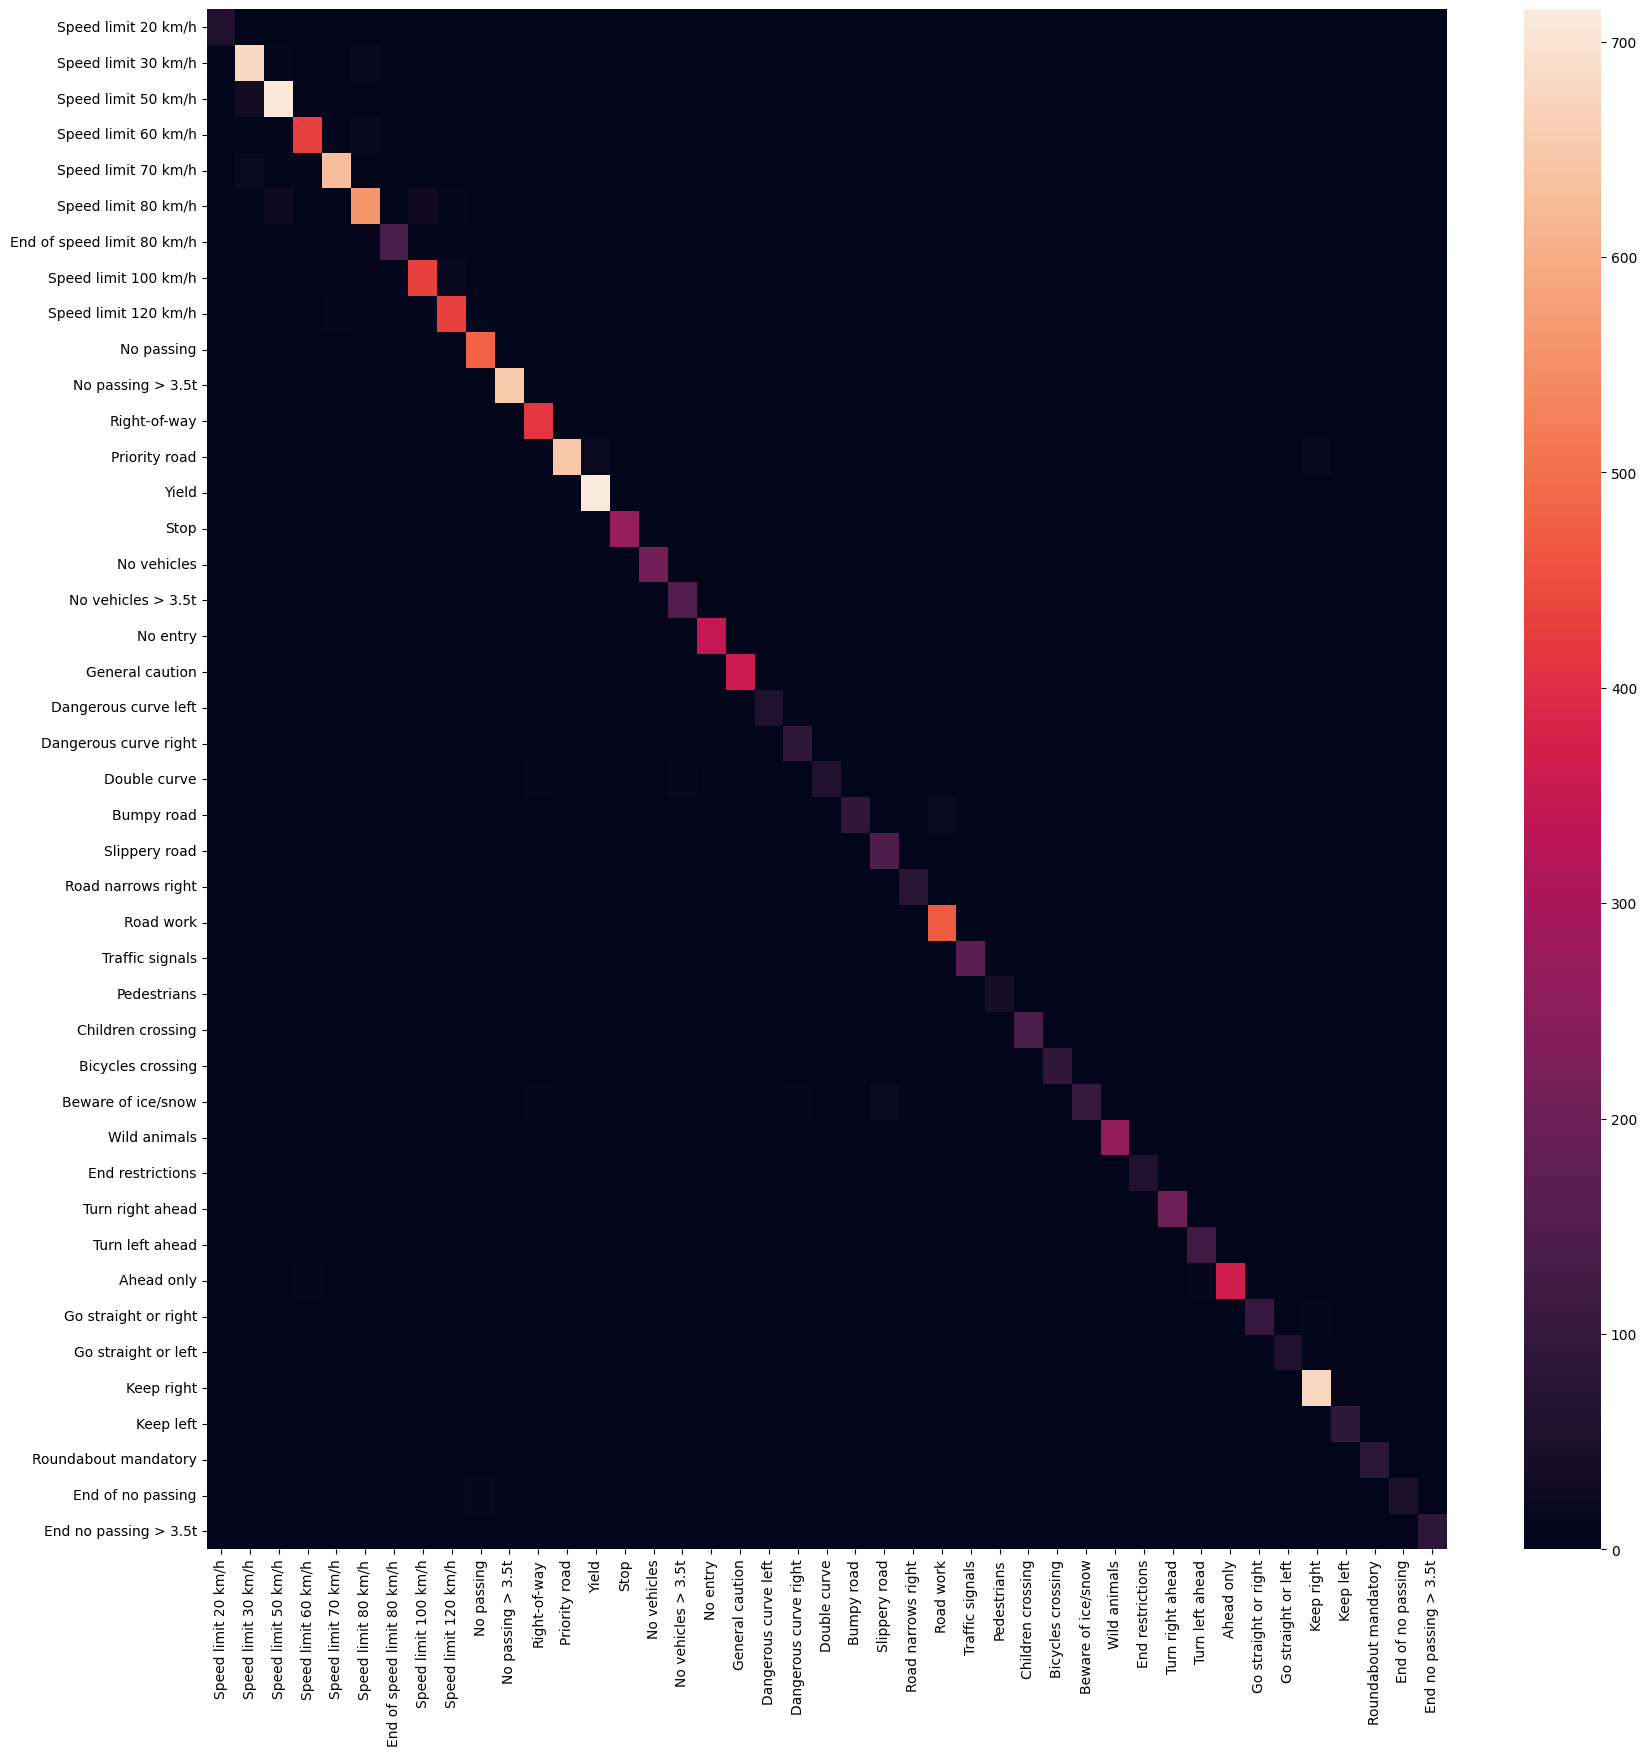

In [25]:
cm = confusion_matrix(y_test, pred)
class_names = [CLASSES[i] for i in range(NUM_CLASSES)]

plt.figure(figsize=(20, 20))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=False)
plt.show()

Save Model

In [26]:
model.save("gtsrb_model.h5")

In [46]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model("gtsrb_model.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save TFLite model
with open("gtsrb_model.tflite", "wb") as f:
    f.write(tflite_model)

print(" TFLite model saved as gtsrb_model.tflite")


Saved artifact at '/tmp/tmptee_7t67'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 30, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)
Captures:
  139422674397200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139422674388944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139422600647824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139422600646864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139422600647248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139422600647440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139422600650896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139422600650128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139422600654928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139422600652624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139422600648208:

In [50]:
from google.colab import files
files.download("gtsrb_model.tflite")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:

!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 17.9 MB/s eta 0:00:00


In [49]:
%%writefile app.py
import streamlit as st
import tflite_runtime.interpreter as tflite
import numpy as np
import cv2
from PIL import Image

# ----------------------------
# Page Configuration
# ----------------------------
st.set_page_config(
    page_title="Traffic Sign Recognition",
    page_icon="🚦",
    layout="centered"
)

st.title("🚦 Traffic Sign Recognition System")
st.write("Upload a traffic sign image to get its meaning and driving rule.")

# ----------------------------
# Load TFLite Model
# ----------------------------
@st.cache_resource
def load_model():
    interpreter = tf.lite.Interpreter(model_path="gtsrb_model.tflite")
    interpreter.allocate_tensors()
    return interpreter

interpreter = load_model()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

IMG_SIZE = 30

# ----------------------------
# GTSRB Sign Info
# ----------------------------
GTSRB_INFO = {
    0: 'Speed limit 20 km/h', 1: 'Speed limit 30 km/h', 2: 'Speed limit 50 km/h',
    3: 'Speed limit 60 km/h', 4: 'Speed limit 70 km/h', 5: 'Speed limit 80 km/h',
    6: 'End of speed limit 80 km/h', 7: 'Speed limit 100 km/h',
    8: 'Speed limit 120 km/h', 9: 'No passing',
    10: 'No passing > 3.5t', 11: 'Right-of-way',
    12: 'Priority road', 13: 'Yield', 14: 'Stop',
    15: 'No vehicles', 16: 'No vehicles > 3.5t',
    17: 'No entry', 18: 'General caution',
    19: 'Dangerous curve left', 20: 'Dangerous curve right',
    21: 'Double curve', 22: 'Bumpy road',
    23: 'Slippery road', 24: 'Road narrows right',
    25: 'Road work', 26: 'Traffic signals',
    27: 'Pedestrians', 28: 'Children crossing',
    29: 'Bicycles crossing', 30: 'Beware of ice/snow',
    31: 'Wild animals', 32: 'End restrictions',
    33: 'Turn right ahead', 34: 'Turn left ahead',
    35: 'Ahead only', 36: 'Go straight or right',
    37: 'Go straight or left', 38: 'Keep right',
    39: 'Keep left', 40: 'Roundabout mandatory',
    41: 'End of no passing', 42: 'End no passing > 3.5t'
}

# ----------------------------
# Image Upload
# ----------------------------
uploaded_file = st.file_uploader(
    "Upload Traffic Sign Image",
    type=["jpg", "png", "jpeg"]
)

if uploaded_file:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", width=300)

    img = np.array(image)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)

    interpreter.set_tensor(input_details[0]["index"], img)
    interpreter.invoke()
    preds = interpreter.get_tensor(output_details[0]["index"])

    class_id = int(np.argmax(preds))
    confidence = float(np.max(preds)) * 100

    name, desc, rule = GTSRB_INFO.get(
        class_id,
        ("Unknown sign", "No description available", "Proceed carefully")
    )

    st.success(f"🚦 **Sign:** {name}")
    st.info(f"📘 **Description:** {desc}")
    st.warning(f"🚗 **Driving Rule:** {rule}")
    st.metric("Confidence", f"{confidence:.2f}%")

else:
    st.warning("Please upload a traffic sign image.")
    st.title("🚦 Traffic Sign Recognition System")
    st.caption("Made by Madhuvanthi")




Overwriting app.py


In [44]:
from google.colab import files
files.download("app.py")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
!ls


app.py	class_names.json  gtsrb_model.h5  gtsrb_model.tflite  sample_data
